In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [26]:
# Create Gaussian blurs with different widths
nGauss = 4000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# Initialize tensors containing images and labels
images = torch.zeros(nGauss, 1, imgSize, imgSize)
labels = torch.zeros(nGauss, 3)

for i in range(nGauss):
    # Location and width parameters
    loc = np.max(x) / 2 * np.random.randn(2)  # Center co-ordinate
    wid = np.random.rand() * 10 + 5  # width of the Gaussian

    # Create the Gaussian with random center
    G = np.exp(-((X - loc[0]) ** 2 + (Y - loc[1]) ** 2) / wid)
    G = G + np.random.randn(imgSize, imgSize) / 10

    # Add to the tensors
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i, :] = torch.Tensor([loc[0], loc[1], wid])

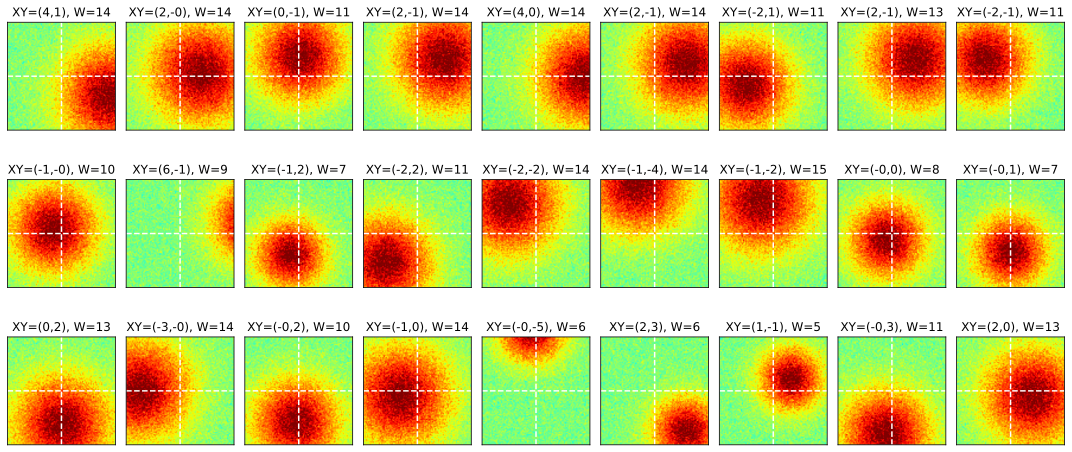

In [27]:
# Visualize some image
fig, axs = plt.subplots(3, 9, figsize=(15, 7))

for i, ax in enumerate(axs.flatten()):
    whichPic = np.random.randint(nGauss)  # Find a random image
    G = np.squeeze(images[whichPic])
    ax.imshow(
        G.cpu(), vmin=-1, vmax=1, cmap="jet", extent=[-4, 4, -4, 4], origin="upper"
    )
    ax.set_title(
        f"XY=({labels[whichPic,0]:.0f},{labels[whichPic,1]:.0f}), W={labels[whichPic,2]:.0f}"
    )
    ax.plot([-4, 4], [0, 0], "w--")
    ax.plot([0, 0], [-4, 4], "w--")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [28]:
# Create Train and Test groups with dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

# Convert data in pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device=device))

# Verify the shape of the data
print(f'Train dataset shape: {train_loader.dataset.tensors[0].shape}')
print(f'Test dataset shape: {test_loader.dataset.tensors[0].shape}')

Train dataset shape: torch.Size([3200, 1, 91, 91])
Test dataset shape: torch.Size([800, 1, 91, 91])


In [29]:
# Function to create Deep Learning model

def createTheModel():
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()

            # All layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                # Conv/pool block 1
                nn.Conv2d(1, 6, 3, padding=1), # Output size: (91 + 2*1 - 3) / 1 + 1 = 91
                nn.ReLU(),
                nn.AvgPool2d(2, 2), # Output Size = 91 / 2 = 45

                # Conv/pool block 2
                nn.Conv2d(6, 4, 3, padding=1), # Output size: (45 + 2*1 - 3) / 1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2, 2), # Output Size = 45 / 2 = 22

                # Linear decision layer
                nn.Flatten(),
                nn.Linear(22*22*4, 50),
                nn.Linear(50, 3)
            )
        
        # Forward Pass
        def forward(self, x):
            return self.enc(x)
        
    # Create Model instance
    net = gauss_net()

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [30]:
# Test the model with one batch
net, lossFun, optimizer = createTheModel()

# Some data to test with
X, y = next(iter(train_loader))
yHat = net(X)

# check the output size of the yHat
print(f'yHat shape: {yHat.shape}\n')

# check the loss
loss = lossFun(yHat, y)
print(f'Loss: {loss}\n')

yHat shape: torch.Size([16, 3])

Loss: 29.62313461303711



In [31]:
# Create the model summery
summary(net, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 3]                   153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 3]                   153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

In [32]:
# Create a function to train the model
def function_to_train_the_model(epochs=50):
    # Create the model
    net, lossFun, optimizer = createTheModel()

    # Initialize the losses
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)

    # The Loop
    for epoch in range(epochs):
        net.train()
        batchLoss = []

        for X, y in train_loader:
            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for the batch
            batchLoss.append(loss.cpu().item())
        
        # Average loss for the epoch
        trainLoss[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, y)

        # Test Loss
        testLoss[epoch] = loss.cpu().item()
    # End of the epoch

    return trainLoss, testLoss, net
    

In [33]:
trainLoss, testLoss, net = function_to_train_the_model(epochs=50)

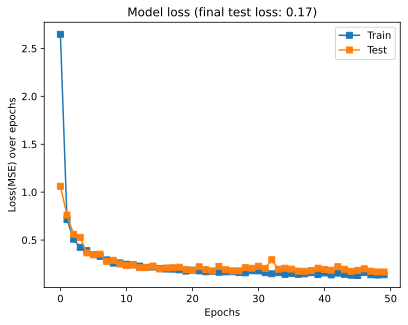

In [35]:
plt.plot(trainLoss.cpu(), 's-', label='Train')
plt.plot(testLoss.cpu(), 's-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss(MSE) over epochs')
plt.legend()
plt.title("Model loss (final test loss: %.2f)" % testLoss[-1])

plt.show()

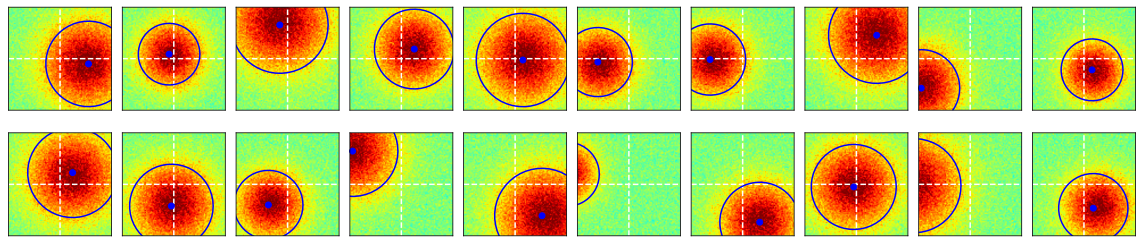

In [36]:
# Visualize some images

X, Y = next(iter(test_loader))  # extract X,y from test dataloader
yHat = net(X)

fig, axs = plt.subplots(2, 10, figsize=(16, 4))

th = np.linspace(0, 2 * np.pi)

for i,ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).cpu().detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')

    # compute the model's prediction
    cx = yHat[i][0].cpu().item() # center X
    cy = yHat[i][1].cpu().item() # center Y
    rd = yHat[i][2].cpu().item() # radius

    # Now let's draw the shape
    x = cx + np.cos(th) * np.sqrt(rd)
    y = cy + np.sin(th) * np.sqrt(rd)
    ax.plot(x, y, 'b')
    ax.plot(cx, cy, 'bo')

    # some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()